**Andrew Lubawy, EE**

**Due: 4/18/2017**
# Simulation and Analysis of a Circuit-Switched Optical Network with Wavelength-Division Multiplexing

***

## Code

In [1]:
%matplotlib inline
from pylab import *
import numpy as np
from scipy.special import factorial
from collections import deque

def metric(dropped, m):
    """Prints the metrics for the simulation in a graph.
    
    Args:
        dropped: The number of dropped connections.
        m: The number of links for each node.
    """
    figure(1)
    plot(m, dropped)
    ylabel("Dropped Connections")
    xlabel("Number of Wavelengths")
    title("Dropped Connections vs Number of Wavelengths")
    show()

This code provides a simulation of a regular optical switching network with wave division multiplexing. It works by keeping track of nodes using a list of lists which tracks what links for each node are open or busy. It will add arrivals to a time counter and drop any connections that had departure times before that arrival. It will then find a route between the start and end node points in the connection which are choden at random. If there isn't one, it will increment a dropped counter otherwise it will add a new departure time to the list making tracking easier.

In [2]:
def simulate_WDM(lamb, mu, n, m, samples):
    """A simulation for circuit-switched optical network.
    
    Simulates wavelength division multiplexing. Connections enter
    a random node and exit from a random node. Only one wavelength will
    be used per route in the network.
    
    Args:
        lamb (float): Arrival rate for incoming connections.
        mu (float): The duration rate for connections.
        n (int): The number of nodes in the network.
        m (int): The number of links for each node.
        samples (int): The number of connection requests to sample.
    """
    # Dropped connection counter.
    dropped = 0
    # Runtime tracker.
    time = 0
    # List containing each node in system.
    node = [];
    # A helper list to track the state of links.
    link = [];
    # Add links to list.
    for i in range(0, m):
        link.append(False)
    # Add nodes to list.
    for i in range(0, n):
        node.append([])
        # Add links for each node.
        for j in range(0, m):
            node[i].append(False)
    # Begin simulation for amount of samples inputted.
    for i in range(0, samples):
        # Reset helper link list.
        for j in range(0, m):
            link[j] = False
        enter, exit = 0, 0
        # Add an arrival interval to time.
        time += exponential(1/lamb)
        # Generate a connection time interval for the arrival.
        departure = exponential(1/mu)
        # Generate random start node and exit node,
        # since order doesn't matter I prefer the traversal
        # to happen from left to right.
        while enter is exit:
            r1 = randint(0,n-1)
            r2 = randint(0, n-1)
            enter = min(r1, r2)
            exit = max(r1, r2)
        # Remove any ended connections before the current time.
        for j in range(enter, exit):
            for k in range(0, m):
                if node[j][k] is not False and node[j][k] <= time:
                    node[j][k] = False
        # Determine available links for route.
        for j in range(enter, exit):
            for k in range(0, m):
                if j is enter:
                    if node[j][k] is False and link[k] is False:
                        link[k] = True
                else:
                    if node[j][k] is not False and link[k] is True:
                        link[k] = False
            # If anytime there are no available links,
            # then the connection cannot be established
            # and it is dropped.
            if link.count(True) is 0:
                dropped += 1
                break
        # If there are any routes available setup the connection.
        if True in link:
            for j in range(enter, exit):
                k = link.index(True)
                node[j][k] = time + departure
    print("\nSimulation of WDM with {0} nodes and W={1}\n".format(n,m))
    print("Simulated dropped probability: {0}\n".format(dropped/samples))
    return dropped

This code performs the same function as above with the exception of random start and end nodes. The start node will always be the first node and the end node will always be the last node. This is effectively an M/M/c/c network.

In [3]:
def simulate_max_travel(lamb, mu, n, m, samples):
    """A simulation for circuit-switched optical network.
    
    Same as simulate_WDM, but connections will traverse the entire network
    and are no longer random as a result.
    
    Args:
        lamb (float): Arrival rate for incoming connections.
        mu (float): The duration rate for connections.
        n (int): The number of nodes in the network.
        m (int): The number of links for each node.
        samples (int): The number of connection requests to sample.
    """
    # Dropped connection counter.
    dropped = 0
    # Time counter.
    time = 0
    node = [];
    link = [];
    for i in range(0, m):
        link.append(False)
    for i in range(0, n):
        node.append([])
        for j in range(0, m):
            node[i].append(False)
    for i in range(0, samples):
        # Reset link helper.
        for j in range(0, m):
            link[j] = False
        # Not random, set route to number of nodes.
        enter, exit = 0, n-1
        time += exponential(1/lamb)
        departure = exponential(1/mu)
        for j in range(enter, exit):
            for k in range(0, m):
                if node[j][k] is not False and node[j][k] <= time:
                    node[j][k] = False
        for j in range(enter, exit):
            for k in range(0, m):
                if j is enter:
                    if node[j][k] is False and link[k] is False:
                        link[k] = True
                else:
                    if node[j][k] is not False and link[k] is True:
                        link[k] = False
            if link.count(True) is 0:
                dropped += 1
                break
        if True in link:
            for j in range(enter, exit):
                k = link.index(True)
                node[j][k] = time + departure
    a = lamb/mu
    l = []
    top = (a**m)/factorial(m, True)
    for i in range(0, m):
        l.append((a**i)/factorial(i, True))
    bottom = sum(l) + top
    erlangb = top/bottom
    print("\nSimulation of max traversal WDM (M/M/c/c) with {0} nodes and W={1}\n".format(n,m))
    print("Expected drop probability: {0}\n".format(erlangb))
    print("Simulated drop probability: {0}\n".format(dropped/samples))
    return dropped

This code also does the same as the above, but the route finding method is less strict. The route can be any wavelength so long as it is open, so it should drop less than the above.

In [4]:
def simulate_w_conversion(lamb, mu, n, m, samples):
    """A simulation for circuit-switched optical network.
    
    Same as simulate_WDM, but multiple wavelengths can be used for a route.
    
    Args:
        lamb (float): Arrival rate for incoming connections.
        mu (float): The duration rate for connections.
        n (int): The number of nodes in the network.
        m (int): The number of links for each node.
        samples (int): The number of connection requests to sample.
    """
    dropped = 0
    time = 0
    node = [];
    link = [];
    for i in range(0, m):
        link.append(False)
    for i in range(0, n):
        node.append([])
        for j in range(0, m):
            node[i].append(False)
    for i in range(0, samples):
        skip = False
        enter, exit = 0, 0
        time += exponential(1/lamb)
        departure = exponential(1/mu)
        while enter is exit:
            r1 = randint(0,n-1)
            r2 = randint(0, n-1)
            enter = min(r1, r2)
            exit = max(r1, r2)
        for j in range(enter, exit):
            for k in range(0, m):
                if node[j][k] is not False and node[j][k] <= time:
                    node[j][k] = False
        # Just check to see if any link is available.
        for j in range(enter, exit):
            if node[j].count(False) is 0:
                dropped += 1
                skip = True
                break
        if skip is not True:
            for j in range(enter, exit):
                k = node[j].index(False)
                node[j][k] = time + departure
    print("\nSimulation of wavelength conversion with {0} nodes and W={1}\n".format(n,m))
    print("Simulated dropped probability: {0}\n".format(dropped/samples))
    return dropped

***
## Results
### Regular WDM Configuration:


Simulation of WDM with 10 nodes and W=2

Simulated dropped probability: 0.4760375


Simulation of WDM with 10 nodes and W=4

Simulated dropped probability: 0.187725


Simulation of WDM with 10 nodes and W=6

Simulated dropped probability: 0.0498125


Simulation of WDM with 10 nodes and W=8

Simulated dropped probability: 0.0084


Simulation of WDM with 10 nodes and W=10

Simulated dropped probability: 0.0007625



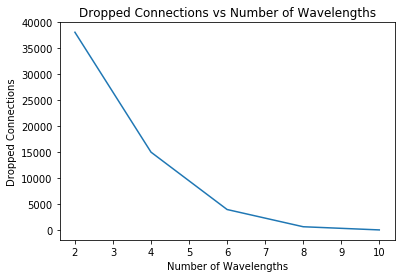

In [5]:
i = 2
dropped, m = [], []
while i <= 10:
    m.append(i)
    dropped.append(simulate_WDM(5, 1, 10, i, 80000))
    i += 2
metric(dropped, m)

### First to Last Node Routing Configuration:


Simulation of max traversal WDM (M/M/c/c) with 10 nodes and W=2

Expected drop probability: 0.6756756756756757

Simulated drop probability: 0.675275


Simulation of max traversal WDM (M/M/c/c) with 10 nodes and W=4

Expected drop probability: 0.39834289356277885

Simulated drop probability: 0.40175


Simulation of max traversal WDM (M/M/c/c) with 10 nodes and W=6

Expected drop probability: 0.19184725888636503

Simulated drop probability: 0.1923875


Simulation of max traversal WDM (M/M/c/c) with 10 nodes and W=8

Expected drop probability: 0.07004785220956705

Simulated drop probability: 0.0694


Simulation of max traversal WDM (M/M/c/c) with 10 nodes and W=10

Expected drop probability: 0.01838457033664814

Simulated drop probability: 0.01895



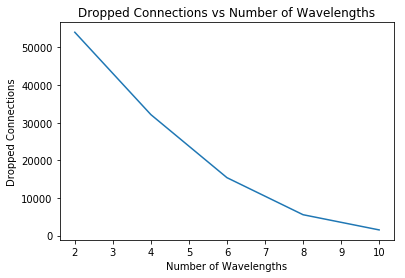

In [6]:
i = 2
dropped, m = [], []
while i <= 10:
    m.append(i)
    dropped.append(simulate_max_travel(5, 1, 10, i, 80000))
    i += 2
metric(dropped, m)

### Wavelength Conversion Routing Configuration:


Simulation of wavelength conversion with 10 nodes and W=2

Simulated dropped probability: 0.470125


Simulation of wavelength conversion with 10 nodes and W=4

Simulated dropped probability: 0.1761625


Simulation of wavelength conversion with 10 nodes and W=6

Simulated dropped probability: 0.0438375


Simulation of wavelength conversion with 10 nodes and W=8

Simulated dropped probability: 0.0064625


Simulation of wavelength conversion with 10 nodes and W=10

Simulated dropped probability: 0.0006875



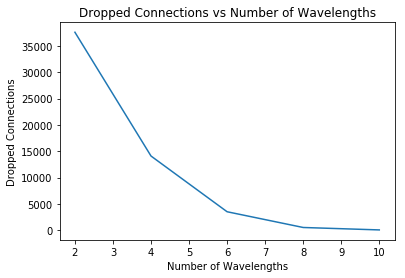

In [7]:
i = 2
dropped, m = [], []
while i <= 10:
    m.append(i)
    dropped.append(simulate_w_conversion(5, 1, 10, i, 80000))
    i += 2
metric(dropped, m)

***
## Conclusions
The first configuration makes sense. As more frequencies are added to the nodes, the number of dropped connections decreases. It is interesting to see it dropping exponentially, but this is to be expected. Increasing the number of links in the network will only give so much improvement so long as the links are being fully utilized. This ties into the $a=\lambda/\mu$ value.

The second configuration also follows my prediction. It behaves like an M/M/c/c network. My simulated results were also within my calculations for an M/M/c/c network using Eralng B to find the theoretical dropping probability. This provides a good metric to determine if my first configuration numbers are at least close to where they should be. Those numbers should be smaller than the second configuration numbers because the length of the route is changing while this configuration is the worst-case length for the first cnfiguration.

The third configuration had very interesting results. It showed minimal performance gain when compared to the first configuration. If wavelength conversion really is expensive technology then I am inclined to believe it is not worth the price according to my simulated numbers. However, at the higher links counts, I did notice drastic performance increase where conversion halved the dropped connections. This may be something to consider if extreme reliability is a factor and if there are enough links to utilize the network well enough.